In [14]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import alexnet
import torchvision
from torchvision import datasets
from collections import OrderedDict
from tqdm import tqdm

from fftKAN import NaiveFourierKANLayer
from fftKANConv import NaiveFourierKANConv

# Import the CIFAR-10 dataset
datasets.CIFAR10(root='./data', train=True, download=True)

# Create the comvolutions and avgpool adapted for a 32*32 input size

def get_model():

    features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    features_KAN = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
        NaiveFourierKANConv(64, 64, gridsize=3, smooth_initialization=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 192, kernel_size=3, padding=1),
        NaiveFourierKANConv(192, 192, gridsize=3, smooth_initialization=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(192, 256, kernel_size=3, padding=1),
        NaiveFourierKANConv(256, 256, gridsize=3, smooth_initialization=True),
    )
    avgpool = nn.AdaptiveAvgPool2d((4, 4))
    classifier_AlexNet = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(),
        nn.Linear(256 * 4 * 4, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, 10),
        nn.LogSoftmax(dim=1)
    )
    classifier_KAN = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(),
        NaiveFourierKANLayer(256 * 4 * 4, 100, gridsize=7, smooth_initialization=True),
        nn.Dropout(),
        NaiveFourierKANLayer(100, 10, gridsize=5, smooth_initialization=True),
        nn.LogSoftmax(dim=1)
    )

    AlexNet_model = nn.Sequential(OrderedDict([
        ('features', features),
        ('avgpool', avgpool),
        ('classifier', classifier_AlexNet)
    ]))
    KAN_model = nn.Sequential(OrderedDict([
        ('features', features),
        ('avgpool', avgpool),
        ('classifier', classifier_KAN)
    ]))

    FullKAN_model = nn.Sequential(OrderedDict([
        ('features', features_KAN),
        ('avgpool', avgpool),
        ('classifier', classifier_KAN)
    ]))

    return AlexNet_model, KAN_model, FullKAN_model

def show_layers(model):
    size = 32, 32, 3
    print("Initial size:", size)

    for layer in [*model.features, model.avgpool, *model.classifier]:
        print(" ", end="")
        if isinstance(layer, nn.Conv2d):
            size = (size[0] - layer.kernel_size[0] + 2 * layer.padding[0]) // layer.stride[0] + 1, \
                (size[1] - layer.kernel_size[1] + 2 * layer.padding[1]) // layer.stride[1] + 1, \
                layer.out_channels
            print("Conv to:", size)
        if isinstance(layer, nn.MaxPool2d):
            size = (size[0] - layer.kernel_size) // layer.stride + 1, \
                (size[1] - layer.kernel_size) // layer.stride + 1, \
                size[2]
            print("Pool to:", size)
        if isinstance(layer, nn.ReLU):
            print("ReLU")
        if isinstance(layer, nn.AdaptiveAvgPool2d):
            size = layer.output_size[0], layer.output_size[1], size[2]
            print("AvgP to:", size)
        if isinstance(layer, nn.Flatten):
            size = size[0] * size[1] * size[2]
            print("Flat to:", size)
        if isinstance(layer, nn.Linear):
            size = layer.out_features
            print("Lin. to:", size)
        if isinstance(layer, NaiveFourierKANLayer):
            size = layer.outdim
            print("KAN to: ", size)
        if isinstance(layer, NaiveFourierKANConv):
            size = *size[:-1], layer.outdim
            print("KANConv to: ", size)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [15]:
model, KAN_model, FullKAN_model = get_model()

# Print the number of parameters of the full models
print(sum(p.numel() for p in model.parameters()), "\t AlexNet parameters")
print(sum(p.numel() for p in KAN_model.parameters()), "\t KAN parameters")
print(sum(p.numel() for p in FullKAN_model.parameters()), "\t Full KAN parameters")

print()

# Print the number of parameters of the classifiers
print(sum(p.numel() for p in model.classifier.parameters()), "\t AlexNet classifier parameters")
print(sum(p.numel() for p in KAN_model.classifier.parameters()), "\t KAN classifier parameters")
print(sum(p.numel() for p in FullKAN_model.classifier.parameters()), "\t Full KAN classifier parameters")

print()

# Print the number of parameters of the features
print(sum(p.numel() for p in model.features.parameters()), "\t AlexNet features parameters")
print(sum(p.numel() for p in KAN_model.features.parameters()), "\t KAN features parameters")
print(sum(p.numel() for p in FullKAN_model.features.parameters()), "\t Full KAN features parameters")

# Print the size of the layers
print("\nAlexNet")
show_layers(model)

print("\nKAN")
show_layers(KAN_model)

print("\nFull KAN")
show_layers(FullKAN_model)

35855178 	 AlexNet parameters
7996094 	 KAN parameters
6939198 	 Full KAN parameters

33603594 	 AlexNet classifier parameters
5744510 	 KAN classifier parameters
5744510 	 Full KAN classifier parameters

2251584 	 AlexNet features parameters
2251584 	 KAN features parameters
1194688 	 Full KAN features parameters

AlexNet
Initial size: (32, 32, 3)
 Conv to: (32, 32, 64)
 ReLU
 Pool to: (16, 16, 64)
 Conv to: (16, 16, 192)
 ReLU
 Pool to: (8, 8, 192)
 Conv to: (8, 8, 384)
 ReLU
 Conv to: (8, 8, 256)
 ReLU
 Conv to: (8, 8, 256)
 ReLU
 Pool to: (4, 4, 256)
 AvgP to: (4, 4, 256)
 Flat to: 4096
  Lin. to: 4096
 ReLU
  Lin. to: 4096
 ReLU
 Lin. to: 10
 
KAN
Initial size: (32, 32, 3)
 Conv to: (32, 32, 64)
 ReLU
 Pool to: (16, 16, 64)
 Conv to: (16, 16, 192)
 ReLU
 Pool to: (8, 8, 192)
 Conv to: (8, 8, 384)
 ReLU
 Conv to: (8, 8, 256)
 ReLU
 Conv to: (8, 8, 256)
 ReLU
 Pool to: (4, 4, 256)
 AvgP to: (4, 4, 256)
 Flat to: 4096
  KAN to:  100
  KAN to:  10
 
Full KAN
Initial size: (32, 32, 3)


In [ ]:
# Train the AlexNet model
model, _, _ = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
pbar = tqdm(range(10)) 
for epoch in pbar:
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        pbar.set_description(f'AlexNet Loss: {loss:02f}')
    torch.save(model.state_dict(), "alexnet_cifar10.pth")

torch.save(model.state_dict(), "alexnet_cifar10.pth")

In [21]:
# Load model
model, _, _ = get_model()
model.load_state_dict(torch.load("alexnet_cifar10.pth"))

# Accuracy of the AlexNet model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

# Accuracy of the AlexNet model per class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]}%')

Accuracy of the network on the 10000 test images: 79.92%
Accuracy of plane: 82.2%
Accuracy of car: 84.3%
Accuracy of bird: 75.3%
Accuracy of cat: 60.1%
Accuracy of deer: 75.3%
Accuracy of dog: 70.3%
Accuracy of frog: 89.2%
Accuracy of horse: 85.8%
Accuracy of ship: 88.1%
Accuracy of truck: 91.2%


In [10]:
alexnet, model, _ = get_model()

# Use pretrained AlexNet model to initialize the KAN model
alexnet.load_state_dict(torch.load("alexnet_cifar10.pth"))
model.features = alexnet.features
model.avgpool = alexnet.avgpool

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
pbar = tqdm(range(10))
for epoch in pbar:
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # We need to clip the grad norms to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        pbar.set_description(f'KAN Loss: {loss:02f}, weight mean: {model.classifier[2].fouriercoeffs.mean():02f}')
    torch.save(model.state_dict(), "kan_cifar10.pth")

torch.save(model.state_dict(), "kan_cifar10.pth")

KAN Loss: 0.070824, weight mean: -0.000004: 100%|██████████| 10/10 [4:53:11<00:00, 1759.19s/it] 


In [6]:
# Load model
_, model, _ = get_model()
model.load_state_dict(torch.load("kan_cifar10.pth"))

# Accuracy of the KAN model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

# Accuracy of the KAN model per class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]}%')

Accuracy of the network on the 10000 test images: 81.85%


In [7]:
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')
for i in range(10):
    print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]}%')

Accuracy of the network on the 10000 test images: 81.85%
Accuracy of plane: 87.1%
Accuracy of car: 90.1%
Accuracy of bird: 67.8%
Accuracy of cat: 65.4%
Accuracy of deer: 86.7%
Accuracy of dog: 71.8%
Accuracy of frog: 85.8%
Accuracy of horse: 81.0%
Accuracy of ship: 88.5%
Accuracy of truck: 87.8%


In [16]:
# Train the Full KAN model
_, _, model = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
pbar = tqdm(range(10))
for epoch in pbar:
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # We need to clip the grad norms to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        pbar.set_description(f'Full KAN Loss: {loss:02f}, weight mean: {model.classifier[2].fouriercoeffs.mean():02f}')
    torch.save(model.state_dict(), "fullkan_cifar10.pth")

torch.save(model.state_dict(), "fullkan_cifar10.pth")

Full KAN Loss: 2.750406, weight mean: 0.000002:   0%|          | 0/10 [30:49<?, ?it/s] 

In [ ]:
# Load model
_, _, model = get_model()
model.load_state_dict(torch.load("fullkan_cifar10.pth"))

# Accuracy of the Full KAN model
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

In [30]:
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si
import torch

# points = torch.array([[0, 0], [1, 2], [3, 1], [4, 5]])

# sample = torch.linspace(-1, 5, 100)

# Function to calculate the B-spline basis function
def b_spline_basis(t, k, i, knots):
    if k == 0:
        return torch.where((knots[i] <= t) & (t < knots[i + 1]), 1.0, 0.0)
    else:
        denom1 = knots[i + k] - knots[i]
        denom2 = knots[i + k + 1] - knots[i + 1]
        
        term1 = ((t - knots[i]) / denom1) * b_spline_basis(t, k - 1, i, knots) if denom1 != 0 else 0.0
        term2 = ((knots[i + k + 1] - t) / denom2) * b_spline_basis(t, k - 1, i + 1, knots) if denom2 != 0 else 0.0
        
        return term1 + term2

# Define non-uniformly spaced x-values and corresponding y-values for control points
x_control = torch.tensor([-3, -1, 0, 2, 4, 5, 7], dtype=torch.float32)
y_control = torch.tensor([0, 2, -2, -3, -1, 0, 5], dtype=torch.float32)

# Degree of the B-spline
degree = 3

# Number of control points
num_control_points = len(x_control)

# Knot vector (adjusted to match the x-values range)
knot_vector = torch.cat((
    torch.full((degree,), x_control[0]),
    x_control,
    torch.full((degree,), x_control[-1])
))

# Function to evaluate the B-spline at a given x-value
def evaluate_b_spline(x):
    y = torch.zeros_like(x)
    for i in range(num_control_points):
        y += y_control[i] * b_spline_basis(x, degree, i, knot_vector)
    return y

# Evaluate the B-spline at a new point
new_point = torch.arange(x_control.min()-1, x_control.max()+1, .2, dtype=torch.float32)
value_at_new_point = evaluate_b_spline(new_point)

# print(f"The value of the B-spline at x = {new_point.item()} is: {value_at_new_point.item()}")

fig = px.line(x=new_point, y=value_at_new_point)
fig.add_scatter(x=x_control, y=y_control, mode='markers+lines')

fig.show()

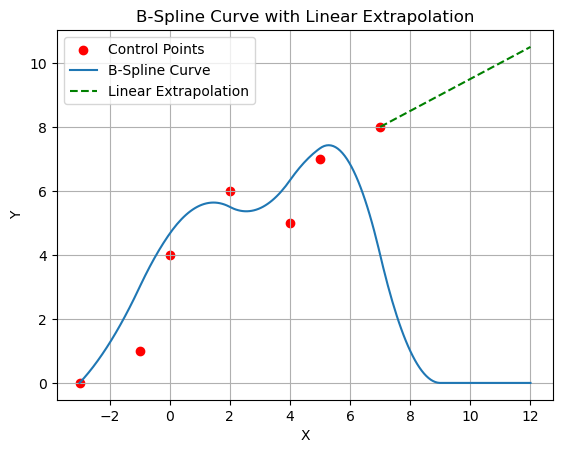

The value of the B-spline at x = 10 is: 9.5


In [27]:
import torch
import matplotlib.pyplot as plt

# Define non-uniformly spaced x-values and corresponding y-values for control points
x_control = torch.tensor([-3, -1, 0, 2, 4, 5, 7], dtype=torch.float32)
y_control = torch.tensor([0, 1, 4, 6, 5, 7, 8], dtype=torch.float32)

# Degree of the B-spline
degree = 2

# Number of control points
num_control_points = len(x_control)

# Knot vector (adjusted for non-uniform spacing and degree)
knot_vector = torch.cat((
    torch.full((degree,), x_control[0]),
    x_control,
    torch.full((degree,), x_control[-1] + (x_control[-1] - x_control[-2]))
))

# Function to calculate the B-spline basis function
def b_spline_basis(t, k, i, knots):
    if k == 0:
        return torch.where((knots[i] <= t) & (t < knots[i + 1]), 1.0, 0.0)
    else:
        denom1 = knots[i + k] - knots[i]
        denom2 = knots[i + k + 1] - knots[i + 1]
        
        term1 = ((t - knots[i]) / denom1) * b_spline_basis(t, k - 1, i, knots) if denom1 != 0 else 0.0
        term2 = ((knots[i + k + 1] - t) / denom2) * b_spline_basis(t, k - 1, i + 1, knots) if denom2 != 0 else 0.0
        
        return term1 + term2

# B-spline evaluation function
def evaluate_b_spline(x):
    y = torch.zeros_like(x)
    for i in range(num_control_points):
        y += y_control[i] * b_spline_basis(x, degree, i, knot_vector)
    return y

# Linear extrapolation function
def linear_extrapolation(x, x1, y1, x2, y2):
    slope = (y2 - y1) / (x2 - x1)
    return y1 + slope * (x - x1)

# Plot the control points
plt.scatter(x_control, y_control, color='red', label='Control Points')

# Plot the B-spline curve
x_values = torch.linspace(x_control[0], x_control[-1] + 5, 200)
y_values = evaluate_b_spline(x_values)

plt.plot(x_values.numpy(), y_values.numpy(), label='B-Spline Curve')

# Extrapolate beyond the control points
x_extrapolate = torch.linspace(x_control[-1], x_control[-1] + 5, 50)
y_extrapolate = linear_extrapolation(x_extrapolate, x_control[-2], y_control[-2], x_control[-1], y_control[-1])

plt.plot(x_extrapolate.numpy(), y_extrapolate.numpy(), 'g--', label='Linear Extrapolation')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('B-Spline Curve with Linear Extrapolation')
plt.grid(True)
plt.show()

# Evaluate B-spline and extrapolation at a specific point
specific_point = 10
value_at_specific_point = evaluate_b_spline(torch.tensor(specific_point, dtype=torch.float32))
if specific_point > x_control[-1]:
    value_at_specific_point = linear_extrapolation(torch.tensor(specific_point, dtype=torch.float32), x_control[-2], y_control[-2], x_control[-1], y_control[-1])
print(f"The value of the B-spline at x = {specific_point} is: {value_at_specific_point.item()}")
